In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
import joblib

In [213]:
df = pd.read_csv("air-quality-in-nairobi.csv") 

In [214]:
df.head()

,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,128;SDS011;68;-1.376;36.929;2019-09-01T00:00:0...
1,128;SDS011;68;-1.376;36.929;2019-09-01T00:00:0...
2,127;DHT22;68;-1.376;36.929;2019-09-01T00:00:05...
3,127;DHT22;68;-1.376;36.929;2019-09-01T00:00:05...
4,79;SDS011;30;-1.290;36.777;2019-09-01T00:00:06...


In [312]:
# Load with semicolon as separator
df = pd.read_csv("air-quality-in-nairobi.csv", sep=";")
df.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,128,SDS011,68,-1.376,36.929,2019-09-01T00:00:02.236776+00:00,P2,7.20
1,128,SDS011,68,-1.376,36.929,2019-09-01T00:00:02.236776+00:00,P1,10.03
2,127,DHT22,68,-1.376,36.929,2019-09-01T00:00:05.613250+00:00,humidity,99.90
3,127,DHT22,68,-1.376,36.929,2019-09-01T00:00:05.613250+00:00,temperature,16.10
4,79,SDS011,30,-1.290,36.777,2019-09-01T00:00:06.128592+00:00,P2,6.93


In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719404 entries, 0 to 719403
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    719404 non-null  int64  
 1   sensor_type  719404 non-null  object 
 2   location     719404 non-null  int64  
 3   lat          719404 non-null  float64
 4   lon          719404 non-null  float64
 5   timestamp    719404 non-null  object 
 6   value_type   719404 non-null  object 
 7   value        719404 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 43.9+ MB


In [314]:
# pivot so each value_type becomes its own column; group by timestamp & location
df_wide = df.pivot_table(
    index=['timestamp','location'],
    columns='value_type',
    values='value',
    aggfunc='mean'
).reset_index()

# Flatten columns
df_wide.columns.name = None
df_wide = df_wide.rename_axis(None, axis=1)
df_wide.head()

,timestamp,location,P1,P2,humidity,temperature
0,2019-09-01T00:00:02.236776+00:00,68,10.03,7.20,NaN,NaN
1,2019-09-01T00:00:05.613250+00:00,68,NaN,NaN,99.9,16.1
2,2019-09-01T00:00:06.128592+00:00,30,10.40,6.93,NaN,NaN
3,2019-09-01T00:00:08.844578+00:00,30,NaN,NaN,99.9,17.3
4,2019-09-01T00:00:09.836965+00:00,59,0.10,0.10,NaN,NaN


In [315]:
# Create AQI labels

def pm25_to_aqi(pm):
    if pd.isna(pm):
        return None
    pm = float(pm)
    if pm <= 12.0:
        return "Good"
    elif pm <= 35.4:
        return "Moderate"
    elif pm <= 55.4:
        return "Unhealthy-Sensitive"
    elif pm <= 150.4:
        return "Unhealthy"
    elif pm <= 250.4:
        return "Very Unhealthy"
    else:
        return "Hazardous"

df_wide['AQI_Category'] = df_wide['P2'].apply(pm25_to_aqi)

def simplify_category(cat):
    if cat in ["Good","Moderate"]:
        return "Healthy"
    else:
        return "Unhealthy"

df_wide['AQI_Binary'] = df_wide['AQI_Category'].apply(simplify_category)
df_wide['AQI_Binary_Num'] = df_wide['AQI_Binary'].map({'Healthy':1, 'Unhealthy':0})

print(df_wide[['P2','AQI_Category','AQI_Binary','AQI_Binary_Num']].head())
print("Class counts:\n", df_wide['AQI_Binary'].value_counts())


     P2 AQI_Category AQI_Binary  AQI_Binary_Num
0  7.20         Good    Healthy               1
1   NaN         None  Unhealthy               0
2  6.93         Good    Healthy               1
3   NaN         None  Unhealthy               0
4  0.10         Good    Healthy               1
Class counts:
 AQI_Binary
Healthy      181366
Unhealthy    178320
Name: count, dtype: int64


In [316]:
df_wide.shape

(359686, 9)

In [317]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359686 entries, 0 to 359685
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       359686 non-null  object 
 1   location        359686 non-null  int64  
 2   P1              186444 non-null  float64
 3   P2              186444 non-null  float64
 4   humidity        173257 non-null  float64
 5   temperature     173257 non-null  float64
 6   AQI_Category    186444 non-null  object 
 7   AQI_Binary      359686 non-null  object 
 8   AQI_Binary_Num  359686 non-null  int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 24.7+ MB


In [318]:
df_wide.isnull().sum()

timestamp              0
location               0
P1                173242
P2                173242
humidity          186429
temperature       186429
AQI_Category      173242
AQI_Binary             0
AQI_Binary_Num         0
dtype: int64

In [319]:
# Numerical columns
num_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical Columns:", num_cols)

# Categorical columns
cat_cols = df_wide.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", cat_cols)


Numerical Columns: ['location', 'P1', 'P2', 'humidity', 'temperature', 'AQI_Binary_Num']
Categorical Columns: ['timestamp', 'AQI_Category', 'AQI_Binary']


In [320]:
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df_wide[col].unique())
    print("Unique count:", df_wide[col].nunique())



Column: timestamp
['2019-09-01T00:00:02.236776+00:00' '2019-09-01T00:00:05.613250+00:00'
 '2019-09-01T00:00:06.128592+00:00' ... '2019-09-30T23:59:48.289841+00:00'
 '2019-09-30T23:59:49.977976+00:00' '2019-09-30T23:59:50.085650+00:00']
Unique count: 359659

Column: AQI_Category
['Good' None 'Moderate' 'Unhealthy' 'Unhealthy-Sensitive' 'Hazardous'
 'Very Unhealthy']
Unique count: 6

Column: AQI_Binary
['Healthy' 'Unhealthy']
Unique count: 2


In [321]:
df_wide.describe()

,location,P1,P2,humidity,temperature,AQI_Binary_Num
count,359686.000000,186444.000000,186444.000000,173257.000000,173257.000000,359686.000000
mean,50.218883,21.653899,11.245230,68.480078,22.996220,0.504234
std,18.575967,34.982505,14.313417,21.373744,9.949977,0.499983
min,7.000000,0.000000,0.000000,22.700000,11.800000,0.000000
25%,29.000000,9.020000,4.870000,51.699829,18.800000,0.000000
50%,61.000000,14.850000,7.700000,65.900000,21.700000,1.000000
75%,68.000000,24.370000,12.930000,89.100000,24.800000,1.000000
max,70.000000,1999.900000,999.900000,99.998474,99.998474,1.000000


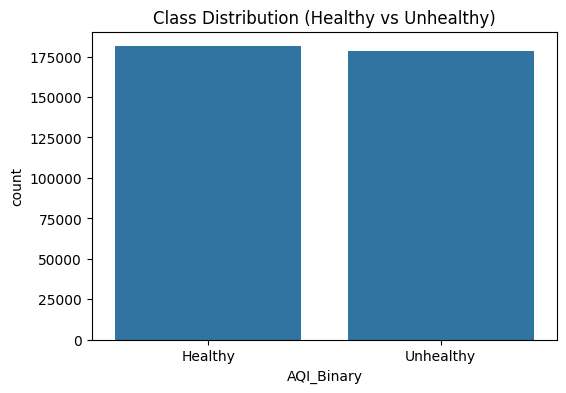

In [226]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_wide, x='AQI_Binary')
plt.title("Class Distribution (Healthy vs Unhealthy)")
plt.show()

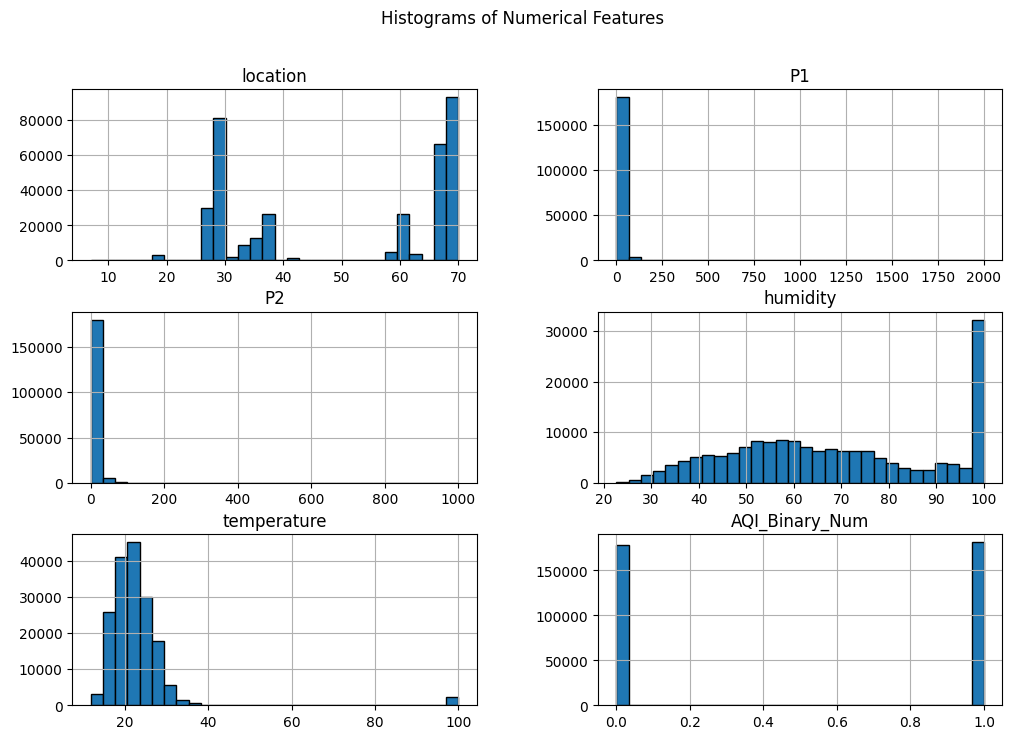

In [227]:
# Numerical columns (excluding timestamp, location, and categorical)
num_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()

# Histograms
df_wide[num_cols].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()

<Figure size 1200x600 with 0 Axes>

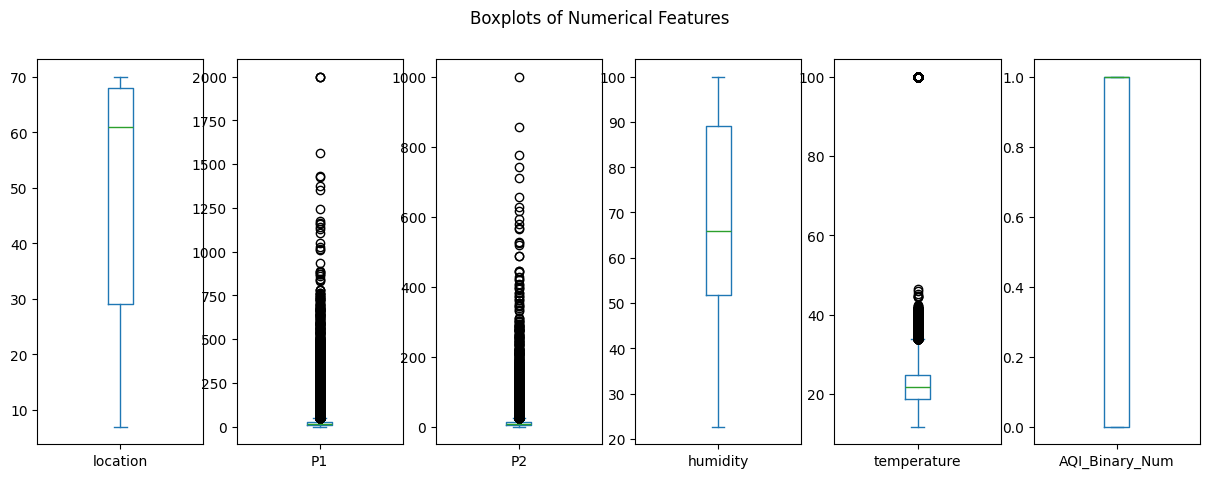

In [228]:
# Boxplots
plt.figure(figsize=(12, 6))
df_wide[num_cols].plot(kind='box', subplots=True, layout=(1, len(num_cols)), figsize=(15, 5), sharey=False)
plt.suptitle("Boxplots of Numerical Features")
plt.show()

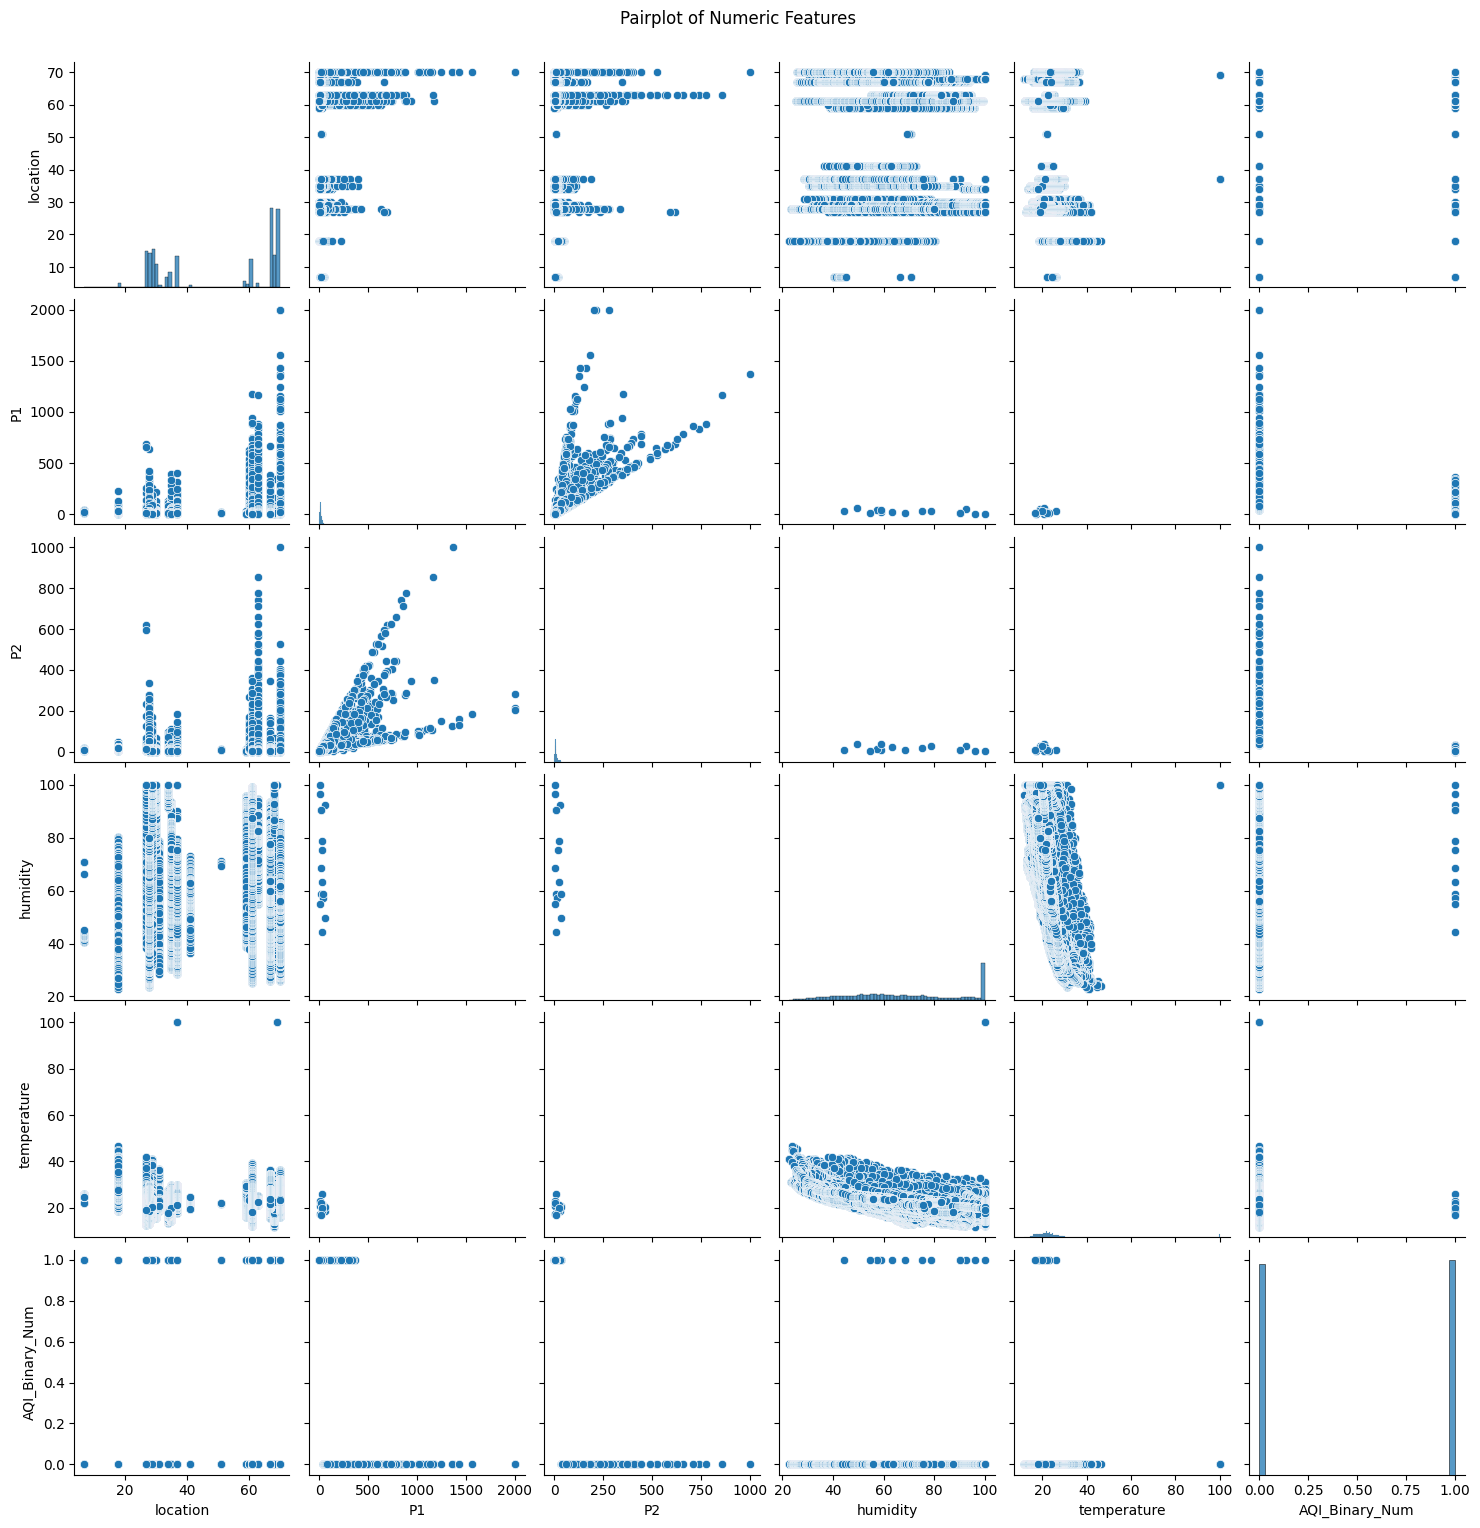

In [229]:
# Pairplot for all numeric columns
sns.pairplot(df_wide[num_cols])
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

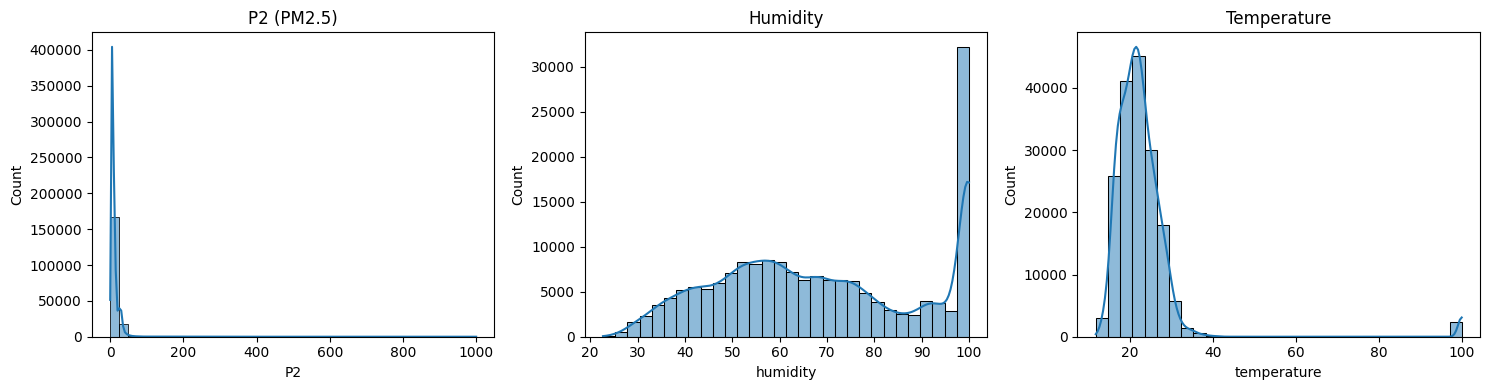

In [14]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df_wide['P2'], bins=40, kde=True, ax=axes[0]).set_title('P2 (PM2.5)')
sns.histplot(df_wide['humidity'], bins=30, kde=True, ax=axes[1]).set_title('Humidity')
sns.histplot(df_wide['temperature'], bins=30, kde=True, ax=axes[2]).set_title('Temperature')
plt.tight_layout()
plt.show()

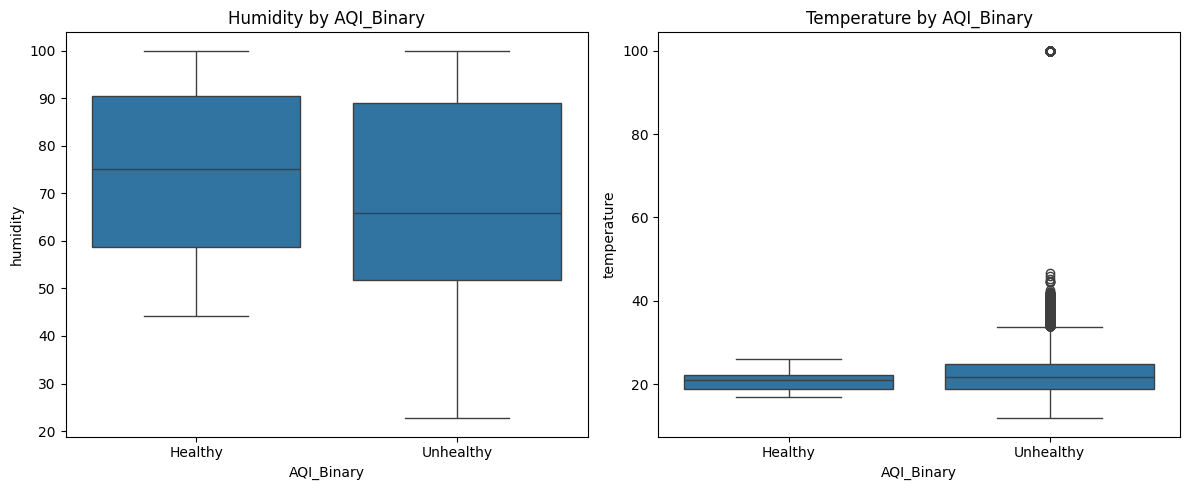

In [15]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(data=df_wide, x='AQI_Binary', y='humidity', ax=axes[0])
axes[0].set_title('Humidity by AQI_Binary')
sns.boxplot(data=df_wide, x='AQI_Binary', y='temperature', ax=axes[1])
axes[1].set_title('Temperature by AQI_Binary')
plt.tight_layout()
plt.show()

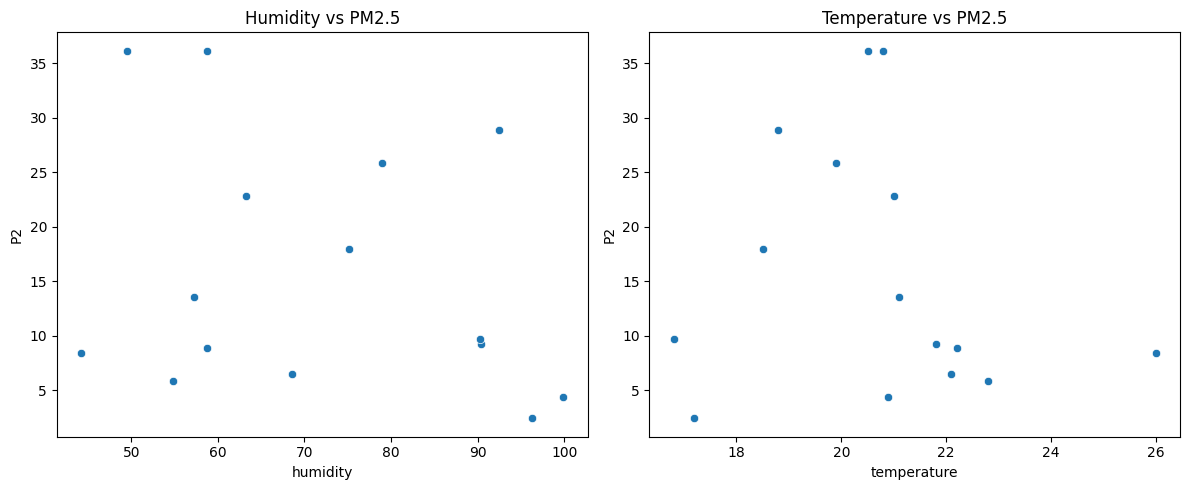

In [25]:
# Example scatter plots between features and P2 (PM2.5)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='humidity', y='P2', data=df_wide)
plt.title("Humidity vs PM2.5")

plt.subplot(1, 2, 2)
sns.scatterplot(x='temperature', y='P2', data=df_wide)
plt.title("Temperature vs PM2.5")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_wide is your DataFrame and num_cols is the list of numeric features
target_col = 'AQI_Binary_Num'

# 1️⃣ Pairplot: all numeric features vs target
sns.pairplot(df_wide, x_vars=num_cols, y_vars=target_col, kind='reg', height=3)
plt.suptitle("Scatterplots of Numeric Features vs Target with Regression Line", y=1.02)
plt.show()

# 2️⃣ Correlation matrix to see linear relationships numerically
corr_cols = num_cols + [target_col]
corr = df_wide[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features and Target")
plt.show()


### Preprocessing

In [322]:
df_wide.columns

Index(['timestamp', 'location', 'P1', 'P2', 'humidity', 'temperature',
       'AQI_Category', 'AQI_Binary', 'AQI_Binary_Num'],
      dtype='object')

In [323]:
# Drop columns not useful for prediction
df_wide.drop(["timestamp", "P1", "P2", "AQI_Category", "AQI_Binary"], axis=1, inplace=True)

# Check remaining columns
print("Remaining columns:", df_wide.columns.tolist())
print(df_wide.info())


Remaining columns: ['location', 'humidity', 'temperature', 'AQI_Binary_Num']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359686 entries, 0 to 359685
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   location        359686 non-null  int64  
 1   humidity        173257 non-null  float64
 2   temperature     173257 non-null  float64
 3   AQI_Binary_Num  359686 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 11.0 MB
None


In [324]:
df_wide.isnull().sum()

location               0
humidity          186429
temperature       186429
AQI_Binary_Num         0
dtype: int64

In [325]:
# Impute missing humidity and temperature with their median
for col in ['humidity', 'temperature']:
    if df_wide[col].isnull().any():
        median_val = df_wide[col].median()
        df_wide[col] = df_wide[col].fillna(median_val)

print(df_wide[['humidity','temperature']].isnull().sum())


humidity       0
temperature    0
dtype: int64


In [ ]:
num

In [326]:


# Function to cap outliers using IQR
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Replace values outside bounds with the bounds
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))
    return df

# Apply capping to humidity and temperature
df_capped = df_wide.copy()
for col in ['humidity', 'temperature']:
    df_capped = cap_outliers_iqr(df_capped, col)

print("Outliers capped for humidity and temperature.")
print(df_capped[['humidity','temperature']].describe())


Outliers capped for humidity and temperature.
           humidity   temperature
count  3.596860e+05  3.596860e+05
mean   6.590000e+01  2.170000e+01
std    2.842175e-14  3.552719e-15
min    6.590000e+01  2.170000e+01
25%    6.590000e+01  2.170000e+01
50%    6.590000e+01  2.170000e+01
75%    6.590000e+01  2.170000e+01
max    6.590000e+01  2.170000e+01


In [327]:
df_wide.isnull().sum()

location          0
humidity          0
temperature       0
AQI_Binary_Num    0
dtype: int64

In [328]:
# Check number of duplicates before removal
print("Duplicate rows in original dataset:", df_wide.duplicated().sum())

# Remove duplicate rows
df_wide = df_wide.drop_duplicates()

# Check number of duplicates after removal
print("Duplicate rows after removal:", df_wide.duplicated().sum())

#  reset the index after dropping
df_wide.reset_index(drop=True, inplace=True)


Duplicate rows in original dataset: 265646
Duplicate rows after removal: 0


In [329]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Use sparse_output=False for newer sklearn
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit + transform
loc_encoded = encoder.fit_transform(df_wide[['location']])

# Get new column names
loc_cols = encoder.get_feature_names_out(['location'])

# Build encoded DataFrame
loc_df = pd.DataFrame(loc_encoded, columns=loc_cols, index=df_wide.index)

# Drop old location and join encoded
df_encoded = pd.concat([df_wide.drop(columns=['location']), loc_df], axis=1)

print("Final columns after encoding:")
print(df_encoded.columns.tolist())


Final columns after encoding:
['humidity', 'temperature', 'AQI_Binary_Num', 'location_7', 'location_18', 'location_27', 'location_28', 'location_29', 'location_30', 'location_31', 'location_34', 'location_35', 'location_37', 'location_41', 'location_51', 'location_59', 'location_60', 'location_61', 'location_63', 'location_67', 'location_68', 'location_69', 'location_70']


### Define features & target

In [330]:
 # Define features (X) and target (y)
X = df_encoded.drop(columns=['AQI_Binary_Num'])
y = df_encoded['AQI_Binary_Num']

### Split the data

In [331]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Scaling

In [332]:
# identify columns
num_standard = ['humidity']         # normal → StandardScaler
num_robust = ['temperature']       
onehot_cols = [c for c in X.columns if c.startswith('location_')]  # already one-hot

# preprocessing
preprocessor = ColumnTransformer([
    ('std', StandardScaler(), num_standard),
    ('rob', RobustScaler(), num_robust),
    ('pass', 'passthrough', onehot_cols)
])


In [333]:
#  Apply SMOTE only on the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [334]:
#  Check the distribution before and after SMOTE
print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts())

Before SMOTE:
AQI_Binary_Num
0    75207
1       25
Name: count, dtype: int64

After SMOTE:
AQI_Binary_Num
0    75207
1    75207
Name: count, dtype: int64


In [335]:
#  Inspecting a few rows of resampled data
X_train_res.head()

,humidity,temperature,location_7,location_18,location_27,location_28,location_29,location_30,location_31,location_34,...,location_41,location_51,location_59,location_60,location_61,location_63,location_67,location_68,location_69,location_70
0,61.800000,24.100000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,46.400000,23.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,46.100000,28.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,36.698914,26.599121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65.900000,18.600000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training and Evaluation

Model: LogisticRegression
Train Accuracy: 0.70
Test Accuracy : 0.74

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.68      0.75      0.71     75207
           1       0.72      0.65      0.68     75207

    accuracy                           0.70    150414
   macro avg       0.70      0.70      0.70    150414
weighted avg       0.70      0.70      0.70    150414

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     18802
           1       0.00      0.33      0.00         6

    accuracy                           0.74     18808
   macro avg       0.50      0.54      0.43     18808
weighted avg       1.00      0.74      0.85     18808



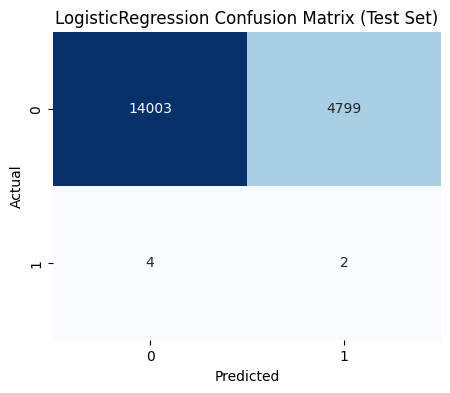


Model: DecisionTree
Train Accuracy: 1.00
Test Accuracy : 1.00

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75207
           1       1.00      1.00      1.00     75207

    accuracy                           1.00    150414
   macro avg       1.00      1.00      1.00    150414
weighted avg       1.00      1.00      1.00    150414

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18802
           1       0.04      0.17      0.07         6

    accuracy                           1.00     18808
   macro avg       0.52      0.58      0.53     18808
weighted avg       1.00      1.00      1.00     18808



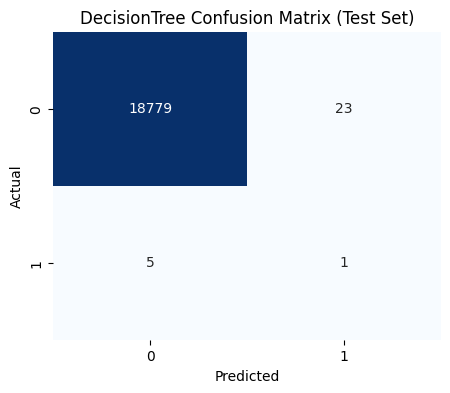


Model: RandomForest
Train Accuracy: 1.00
Test Accuracy : 1.00

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75207
           1       1.00      1.00      1.00     75207

    accuracy                           1.00    150414
   macro avg       1.00      1.00      1.00    150414
weighted avg       1.00      1.00      1.00    150414

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18802
           1       0.06      0.17      0.09         6

    accuracy                           1.00     18808
   macro avg       0.53      0.58      0.54     18808
weighted avg       1.00      1.00      1.00     18808



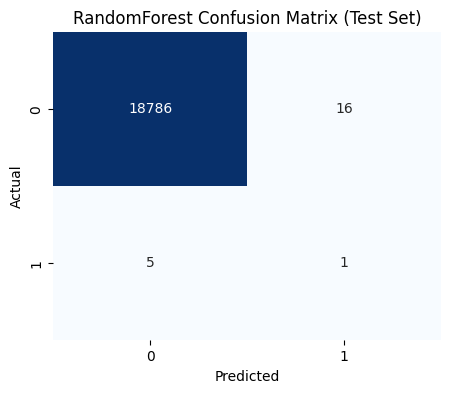


Model: GradientBoosting
Train Accuracy: 0.97
Test Accuracy : 0.98

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     75207
           1       0.98      0.97      0.97     75207

    accuracy                           0.97    150414
   macro avg       0.97      0.97      0.97    150414
weighted avg       0.97      0.97      0.97    150414

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     18802
           1       0.01      0.50      0.01         6

    accuracy                           0.98     18808
   macro avg       0.50      0.74      0.50     18808
weighted avg       1.00      0.98      0.99     18808



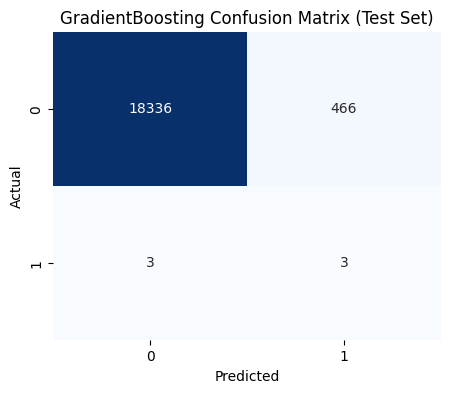


Model: LinearSVM
Train Accuracy: 0.70
Test Accuracy : 0.75

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.68      0.75      0.71     75207
           1       0.72      0.65      0.68     75207

    accuracy                           0.70    150414
   macro avg       0.70      0.70      0.70    150414
weighted avg       0.70      0.70      0.70    150414

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.75      0.85     18802
           1       0.00      0.33      0.00         6

    accuracy                           0.75     18808
   macro avg       0.50      0.54      0.43     18808
weighted avg       1.00      0.75      0.85     18808



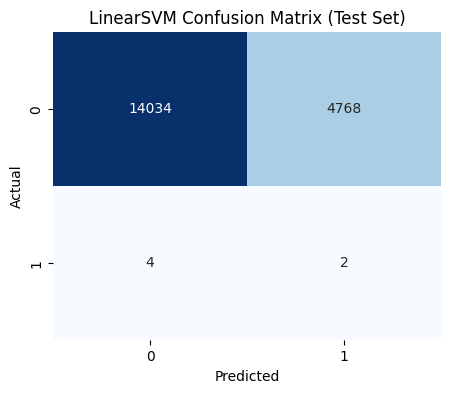

In [337]:


# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LinearSVM': LinearSVC(max_iter=5000, random_state=42)
}

# Iterate over models
for name, model in models.items():
    # Create pipeline: preprocessing + model
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),  # your previously defined ColumnTransformer
        ('classifier', model)
    ])
    
    # Train on SMOTE-resampled data
    pipe.fit(X_train_res, y_train_res)
    
    # Predictions on train and test
    y_train_pred = pipe.predict(X_train_res)
    y_test_pred = pipe.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train_res, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"Model: {name}")
    print("="*60)
    print(f"Train Accuracy: {train_acc:.2f}")
    print(f"Test Accuracy : {test_acc:.2f}\n")
    
    # Classification reports
    print("Classification Report (Training Set):")
    print(classification_report(y_train_res, y_train_pred))
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("="*60, "\n")


In [339]:
import pandas as pd

# Metrics for each model (replace with your actual numbers)
data = {
    "Model": ["LogisticRegression", "DecisionTree", "RandomForest", "GradientBoosting", "LinearSVM"],
    "Train Accuracy": [0.70, 1.00, 1.00, 0.97, 0.70],
    "Test Accuracy": [0.74, 1.00, 1.00, 0.98, 0.75],
    "Train Precision": [0.70, 1.00, 1.00, 0.97, 0.70],
    "Test Precision": [0.50, 0.52, 0.53, 0.50, 0.50],   # Macro average
    "Train Recall": [0.70, 1.00, 1.00, 0.97, 0.70],
    "Test Recall": [0.54, 0.58, 0.58, 0.74, 0.54],       # Macro average
    "Train F1-score": [0.70, 1.00, 1.00, 0.97, 0.70],
    "Test F1-score": [0.43, 0.53, 0.54, 0.50, 0.43]     # Macro average
}

df_metrics = pd.DataFrame(data)

# Display the table
df_metrics


,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score
0,LogisticRegression,0.70,0.74,0.70,0.50,0.70,0.54,0.70,0.43
1,DecisionTree,1.00,1.00,1.00,0.52,1.00,0.58,1.00,0.53
2,RandomForest,1.00,1.00,1.00,0.53,1.00,0.58,1.00,0.54
3,GradientBoosting,0.97,0.98,0.97,0.50,0.97,0.74,0.97,0.50
4,LinearSVM,0.70,0.75,0.70,0.50,0.70,0.54,0.70,0.43


### Hyperparameter Tuning for Gradient Boosting

In [341]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Define Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Smaller hyperparameter grid for faster runtime
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Stratified K-Fold CV (reduce folds to 3 for speed)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized Search CV with fewer iterations
random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=10,           # only 10 random combinations
    scoring='f1',        # focus on F1 for balanced evaluation
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on SMOTE-resampled training data
random_search.fit(X_train_res, y_train_res)

# Show best hyperparameters and CV score
print("Best Hyperparameters found on training data:")
print(random_search.best_params_)
print("\nBest cross-validated F1 score on training data:")
print(random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters found on training data:
{'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}

Best cross-validated F1 score on training data:
0.9979161906986415


In [342]:
#  Train Gradient Boosting on SMOTE-resampled data
best_gb = GradientBoostingClassifier(
    n_estimators=300,       # use your tuned hyperparameters
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

best_gb.fit(X_train_res, y_train_res)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,300
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


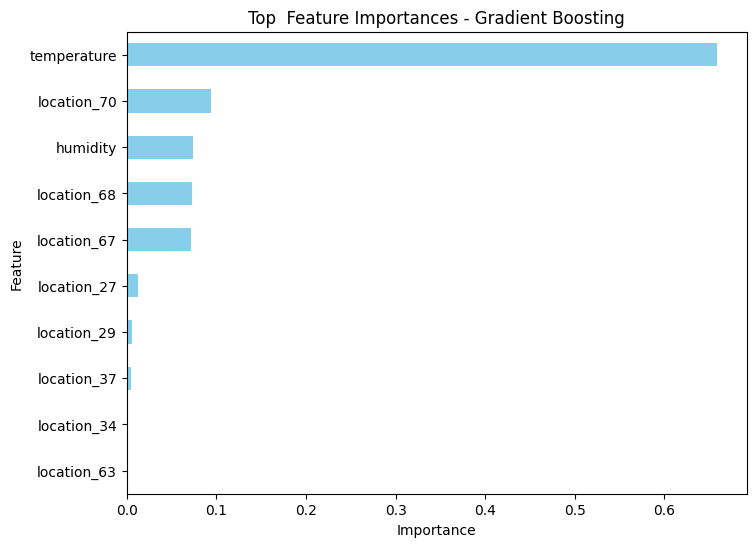

In [346]:

#  Get feature importances
feat_importances = pd.Series(best_gb.feature_importances_, index=X_train_res.columns)

#  Sort and select top 10 features
top_features = feat_importances.sort_values(ascending=False).head(10)

# Step 4: Plot horizontal bar chart
top_features.sort_values().plot(kind='barh', figsize=(8,6), color='skyblue')
plt.title("Top  Feature Importances - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_gb, X_train_res, y_train_res, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation score')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Gradient Boosting")
plt.legend()
plt.show()